In [2]:
from scipy import interpolate
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
f = pd.read_csv("ants.txt", delimiter=',')

In [3]:
f1 = f[f['id']==1]
# f1=f1.sort_values(by=['x'])

In [4]:
f1.drop_duplicates(subset=['x'], inplace=True)

not f1["x"].is_unique

<ipython-input-4-7e075a4a3d40>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f1.drop_duplicates(subset=['x'], inplace=True)


False

In [5]:
max(f1['x'])

2094.8920000000003

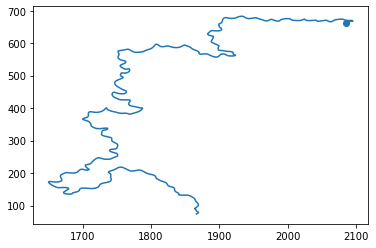

In [6]:
plt.plot(f1['x'],f1['y'])
plt.scatter(f1['x'][0],f1['y'][0])

In [24]:
def get_next_subsection(a,b,c):
    newa = []
    newb = []
    newc = []
    neg = np.sign(a[0]-a[1])
    i = 0
    while(i < len(a)-1 and np.sign(a[i] - a[i+1]) == neg):
        newa.append(a[i])
        newb.append(b[i])
        newc.append(c[i])
        i+=1
    if(neg == 1):
        newa.reverse()
        newb.reverse()
        newc.reverse()
    return newa,newb,newc,i

In [47]:
def get_spline(f1):
    j = 0
    xl = list(f1['x'])
    yl = list(f1['y'])
    tl = list(f1['t'])
    newx = []
    newy = []
    newt = []
    plt.plot(xl, yl)
    while(j < len(f1['x'])-1):
        xj, yj, tj, newj = get_next_subsection(xl[j:],yl[j:],tl[j:])
    #     print(np.shape(tj),np.shape(xj), np.shape(xl[j:]),np.shape(tl[j:]))
        if(len(xj) > 2):
            g = interpolate.CubicSpline(xj, yj, bc_type='natural')
            gt = interpolate.CubicSpline(xj, tj, bc_type='natural')
            x_new = np.arange(min(xj), max(xj), 2)
            y_new = g(x_new)
            t_new = g(x_new)
            newx.append(x_new)
            newy.append(y_new)
            newt.append(t_new)
            plt.plot(x_new, y_new)
        j += newj
    newx = np.concatenate([x.ravel() for x in newx])
    newy = np.concatenate([x.ravel() for x in newy])
    newt = np.concatenate([x.ravel() for x in newt])
    return newx, newy, newt

In [1]:
for i in np.unique(f['id']):
    f1 = f[f['id']==i]
    f1.drop_duplicates(subset=['x'], inplace=True)
    get_spline(f1)

NameError: name 'f' is not defined

In [45]:
newt.size

613